In [1]:
import mysql.connector
from sqlalchemy import create_engine
import pandas as pd

import WorkFunctions as wFunc

In [2]:
link = "mysql+pymysql://root:@127.0.0.1:3306/zyka"
zyka = create_engine(link)
nodes = create_engine(link+'_pdbs_nodes')
edges = create_engine(link+'_pdbs_edges')

# Creating database

In [31]:
%%time
def saveAll():
    protein = "read/Protein - C_NS5"
    fastaProSequences = wFunc.fileRead(protein, ".fa")
    columns=["ID", "Host", "Region", "Date", "FullSeq"]
    #Make DataFrames
    fastaProDF = wFunc.makeDF(columns, fastaProSequences)
    fastaProDF.to_sql("zyka_samples", zyka, if_exists='replace')
    nsFiles = wFunc.readPDBs()
    for key, value in nsFiles.items():
        value.to_sql(str.lower(key), nodes, if_exists='replace')
    nsFiles = wFunc.readPDBs(True)
    for key, value in nsFiles.items():
        value.to_sql(str.lower(key), edges, if_exists='replace')

#saveAll()

Wall time: 5.13 s


# Reading DB

In [36]:
dataList = ['5GS6', '5IY3', '5K6K', '5JMT', "5TMH"]
nodesFiles = {}
edgesFiles = {}
samples = pd.read_sql_query('SELECT * FROM zyka_samples', index_col="index", con=zyka)
for ii in dataList:
    temp = str.lower(ii)
    nodesFiles[ii] = pd.read_sql_query('SELECT * FROM '+temp, index_col="index", con=nodes)
    edgesFiles[ii] = pd.read_sql_query('SELECT * FROM '+temp, index_col="index", con=edges)

In [33]:
import WorkFlow as wFlow
import multiprocessing as mp
from multiprocessing.dummy import Pool as ThreadPool
from tqdm import tqdm

def readOrCreate(nsFiles, samples, delList, saveList, makeTheMagic=False):
    path = "read/ResultCover/allSequencesCover.csv"
    path2 = "read/ResultCover/allSequencesAmino.csv"

    if makeTheMagic:
        print("I'm going to an adventure!")
        obj = wFlow.work()
        """
        1 - PDBs
        2 - Sequences
        3 - showAlign=False
        4 - saveAlign=False
        """
        cover, aminoDegrees = obj.prepareWork(nsFiles, samples, delList)
        aminoDegrees.to_sql("pre_processed_results", zyka, index=False, if_exists='replace')
        cover.to_sql("cover", zyka, index=False, if_exists='replace')

        cleanedDF, strangeDF = cleanData(aminoDegrees, saveList)

        countAndSavePoli(saveList, cleanedDF)
        countAndSavePoli(saveList, cleanedDF, False)

        obj.makeFasta(cover, dataList)

    print("Ok, just reading!")
    cover = pd.read_sql_query('SELECT * FROM cover', con=zyka)
    aminoDegrees = pd.read_sql_query('SELECT * FROM pre_processed_results', con=zyka)
    cleanedDF, strangeDF = cleanData(aminoDegrees, saveList)
    poliListAmino = readSavedPoli(saveList)
    poliListDegree = readSavedPoli(saveList, False)
    
    return cover, aminoDegrees, cleanedDF, strangeDF, poliListAmino, poliListDegree

def fillPosition(df):
    temp = pd.DataFrame()
    for jj, kk in enumerate(df):
        temp.loc[0, str(jj)+"POS"] = kk
        
    return temp


    

def splitCell(seq, amino):
    """
        returna a Aminoacid or a degree value
    """
    seq = seq.split("|")
    if amino:
        seq = [x.split(",")[0] for x in seq]
    else:
        seq = [x.split(",")[1] for x in seq]
    return seq

def countAndSavePoli(dataList, df, amino=True):
    for ii in dataList:
        temp = makeCountDF(df, ii, amino)
        if amino:
            path = "read/PolimorfDF/dfAmino"+ii+".csv"
        else:
            path = "read/PolimorfDF/dfDegree"+ii+".csv"
        temp.to_csv(path, sep="\t", index=True)
        print("PDB: "+ii+" saved!")
        
def cleanData(df, dataList):
    dataCut = {'5GS6' : 1452, '5IY3': 767, '5K6K': 1454, '5JMT': 1835, '5TMH': 3655}
    cleanedDF = pd.DataFrame()
    strangeDF = pd.DataFrame()
    for ii in dataList:
        temp = df[(df.Protein == ii) & (df.Len <= dataCut[ii])]
        temp2 = df[(df.Protein == ii) & (df.Len > dataCut[ii])]
        cleanedDF = pd.concat([cleanedDF, temp])
        strangeDF = pd.concat([strangeDF, temp2])
        
    return cleanedDF, strangeDF
def readSavedPoli(dataList, amino=True):
    temp = []
    for ii in dataList:
        print("Reading PDB: "+ii)
        if amino:
            path = "read/PolimorfDF/dfAmino"+ii+".csv"
        else:
            path = "read/PolimorfDF/dfDegree"+ii+".csv"
        temp.append(pd.read_csv(path, sep="\t", index_col=0))
    return temp

In [34]:
saveList, delList = wFunc.choseOne(-1)
saveList = [str.lower(x) for x in saveList]
nodesFiles = {}
for ii in dataList:
    nodesFiles[ii] = pd.read_sql_query('SELECT * FROM '+ii, index_col="index", con=nodes)

cover, aminoDegrees, cleanedDF, strangeDF, poliListAmino, poliListDegree = readOrCreate(nodesFiles, samples[:2], delList, saveList, True)

I'm going to an adventure!


KeyError: 'the label [0] is not in the [index]'

In [7]:
def makeCountDF(df, proteinID, amino=True):
    selectDF = df[df.Protein == proteinID].Seq.tolist()
    selectDF = [splitCell(x, amino) for x in selectDF]

    temp = pd.DataFrame()
    poolSize = mp.cpu_count()
    pool = ThreadPool(poolSize)
    results = []
    
    for ii in tqdm(pool.imap_unordered(fillPosition, selectDF ), total=len(selectDF)):
        temp = pd.concat([temp, ii], axis=0, sort=False)
    pool.close()
    pool.join()
    
    temp = temp.reset_index()
        
    return temp

makeCountDF(samples[:2], "5gs6", True)

[Empty DataFrame
 Columns: [index]
 Index: [], Empty DataFrame
 Columns: [index]
 Index: [], Empty DataFrame
 Columns: [index]
 Index: [], Empty DataFrame
 Columns: [index]
 Index: [], Empty DataFrame
 Columns: [index]
 Index: []]

In [11]:
import WorkFunctions as wFunc
import WorkFlow as wFlow
import Graphs as gr
import matplotlib.pyplot as plt
nsFiles = wFunc.readPDBs()

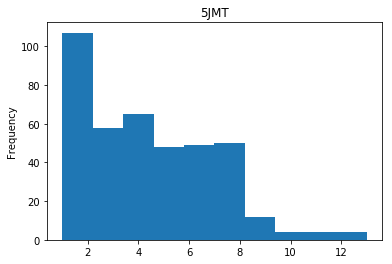

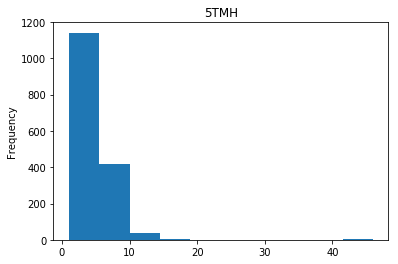

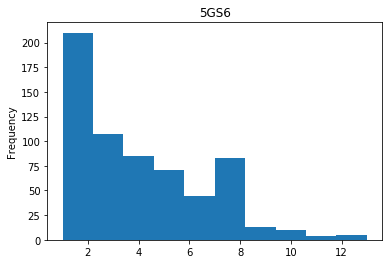

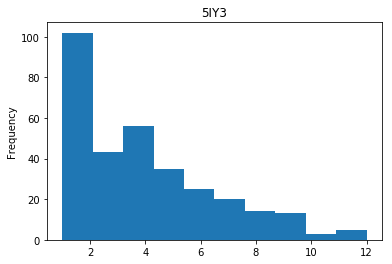

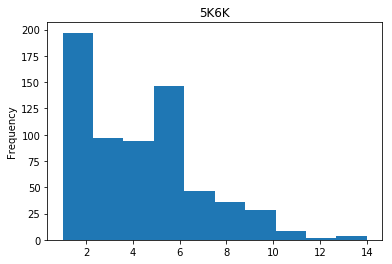

In [32]:
temp = []
for keys in nsFiles:
    nsFiles[keys].Degree.plot(kind="hist", title=keys)
    temp.append(nsFiles[keys].Degree.tolist())
    plt.savefig("imgs/PDBDegree_"+keys+".png", dpi=600)
    plt.show()


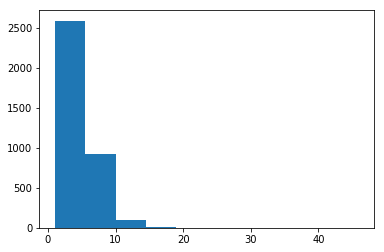

In [31]:
aux = []
for ii in temp:
    for jj in ii:
        aux.append(jj)

plt.hist(aux)#, log=True)
plt.savefig('all.png')
plt.show()